In [1]:
import os
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [2]:
# Define the root folder where the dataset is stored
root_folder = r'C:\Naveen\Plant Disease Kashmiri Apple DL (RAMESH.C)\DATASET\New folder\Corn'

In [3]:
# Initialize lists to hold image paths and labels
image_paths = []
labels = []

In [4]:
# Loop through the folders in the root folder
for folder in os.listdir(root_folder):
    folder_path = os.path.join(root_folder, folder)
    
    # Check if it's a directory (subfolder)
    if os.path.isdir(folder_path):
        # Get all image files in the folder (you can modify the file type if necessary, e.g., *.jpg, *.png)
        image_files = glob(os.path.join(folder_path, '*.*'))  # Use a more specific file extension like '*.jpg' if necessary
        
        # Append the image path and label to the lists
        for image in image_files:
            image_paths.append(image)
            labels.append(folder)  # The folder name is the label

In [5]:
# Create a DataFrame
df = pd.DataFrame({'image_path': image_paths, 'label': labels})

In [6]:
# Display the DataFrame
print(df.head())

                                          image_path        label
0  C:\Naveen\Plant Disease Kashmiri Apple DL (RAM...  Common_Rust
1  C:\Naveen\Plant Disease Kashmiri Apple DL (RAM...  Common_Rust
2  C:\Naveen\Plant Disease Kashmiri Apple DL (RAM...  Common_Rust
3  C:\Naveen\Plant Disease Kashmiri Apple DL (RAM...  Common_Rust
4  C:\Naveen\Plant Disease Kashmiri Apple DL (RAM...  Common_Rust


In [7]:
# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
# Display the DataFrame
print(df.head())

                                          image_path        label
0  C:\Naveen\Plant Disease Kashmiri Apple DL (RAM...  Common_Rust
1  C:\Naveen\Plant Disease Kashmiri Apple DL (RAM...      Healthy
2  C:\Naveen\Plant Disease Kashmiri Apple DL (RAM...  Common_Rust
3  C:\Naveen\Plant Disease Kashmiri Apple DL (RAM...  Common_Rust
4  C:\Naveen\Plant Disease Kashmiri Apple DL (RAM...  Common_Rust


In [9]:
# Check the class distribution
class_counts = df['label'].value_counts()

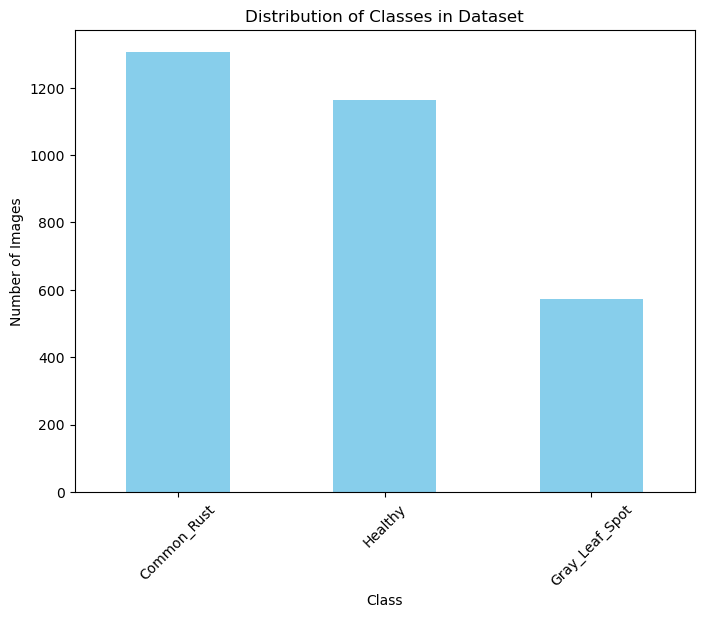

In [10]:
# Plot the distribution of labels (class counts)
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Classes in Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [11]:
# Check basic dataframe info
print("\nDataframe Info:")
print(df.info())


Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3042 entries, 0 to 3041
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3042 non-null   object
 1   label       3042 non-null   object
dtypes: object(2)
memory usage: 47.7+ KB
None


In [12]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)


Missing Values:
image_path    0
label         0
dtype: int64


In [13]:
# Sample some images from each class (example images)
sample_per_class = 3
unique_labels = df['label'].unique()

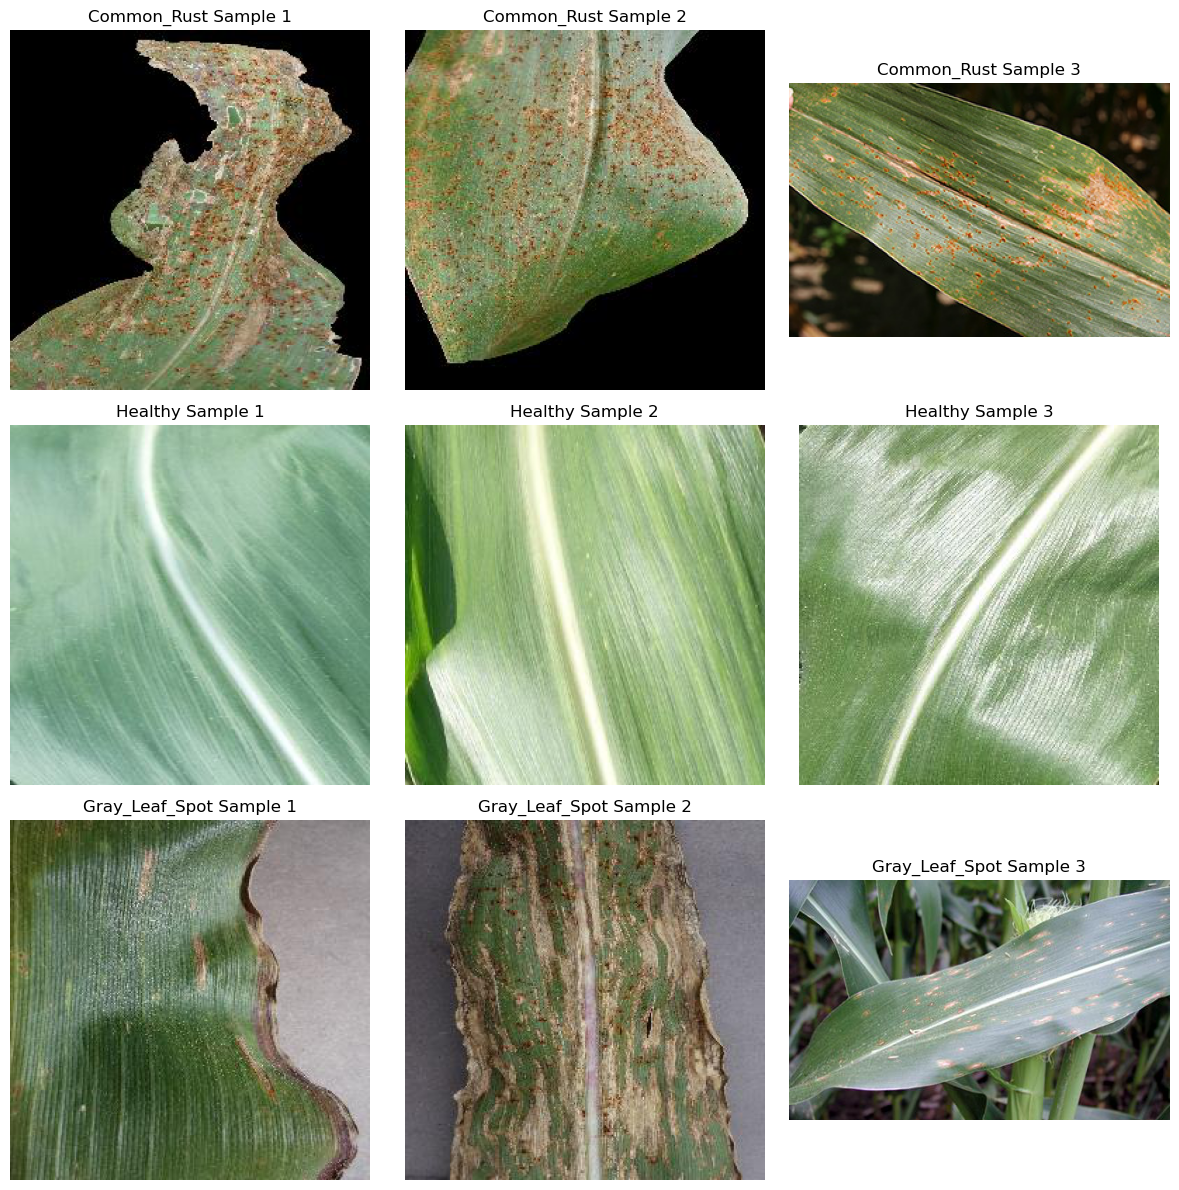

In [14]:
# Create a plot with sample images from each class
plt.figure(figsize=(12, 12))
for i, label in enumerate(unique_labels):
    sample_images = df[df['label'] == label].sample(sample_per_class)['image_path'].values
    for j, img_path in enumerate(sample_images):
        plt.subplot(len(unique_labels), sample_per_class, i * sample_per_class + j + 1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{label} Sample {j+1}")
plt.tight_layout()
plt.show()

In [15]:
df['label'].value_counts()

label
Common_Rust       1306
Healthy           1162
Gray_Leaf_Spot     574
Name: count, dtype: int64

In [16]:
# Resampling: For each class, we will downsample or upsample to 1000 samples
df_resampled = df.groupby('label').apply(lambda x: x.sample(n=1000, random_state=42, replace=True) if len(x) < 1000 else x.sample(n=1000, random_state=42))

C:\Users\Win\AppData\Local\Temp\ipykernel_11548\3636762607.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_resampled = df.groupby('label').apply(lambda x: x.sample(n=1000, random_state=42, replace=True) if len(x) < 1000 else x.sample(n=1000, random_state=42))


In [17]:
# Reset the index after resampling
df_resampled = df_resampled.reset_index(drop=True)

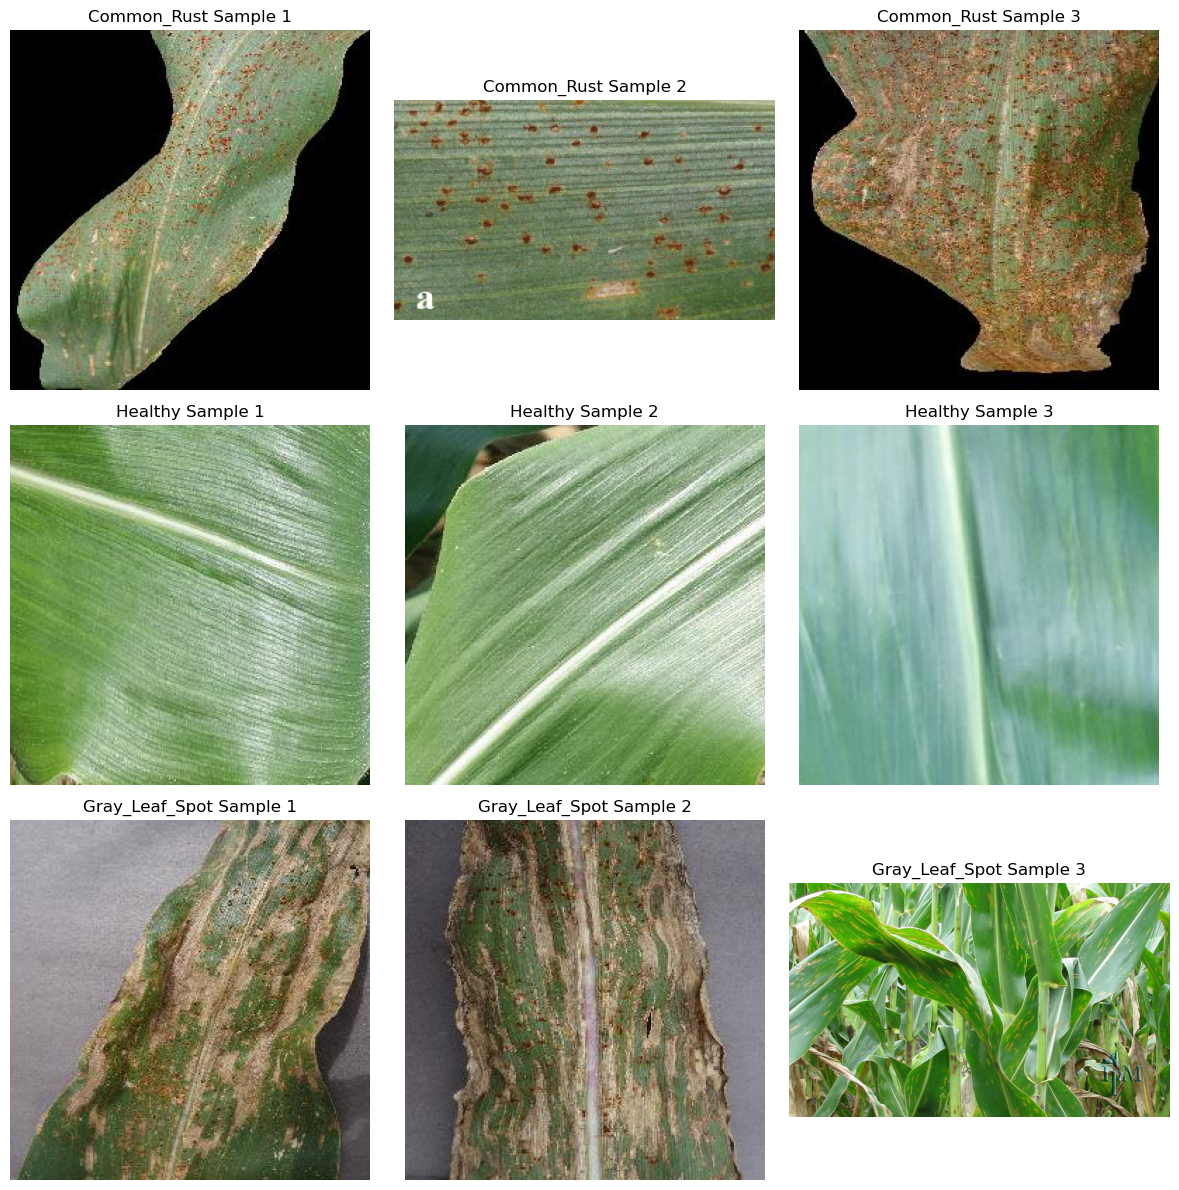

In [18]:
# Create a plot with sample images from each class
plt.figure(figsize=(12, 12))
for i, label in enumerate(unique_labels):
    sample_images = df_resampled[df_resampled['label'] == label].sample(sample_per_class)['image_path'].values
    for j, img_path in enumerate(sample_images):
        plt.subplot(len(unique_labels), sample_per_class, i * sample_per_class + j + 1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{label} Sample {j+1}")
plt.tight_layout()
plt.show()

In [19]:
# Check the new class distribution
print("\nNew Class Distribution After Resampling:")
print(df_resampled['label'].value_counts())


New Class Distribution After Resampling:
label
Common_Rust       1000
Gray_Leaf_Spot    1000
Healthy           1000
Name: count, dtype: int64


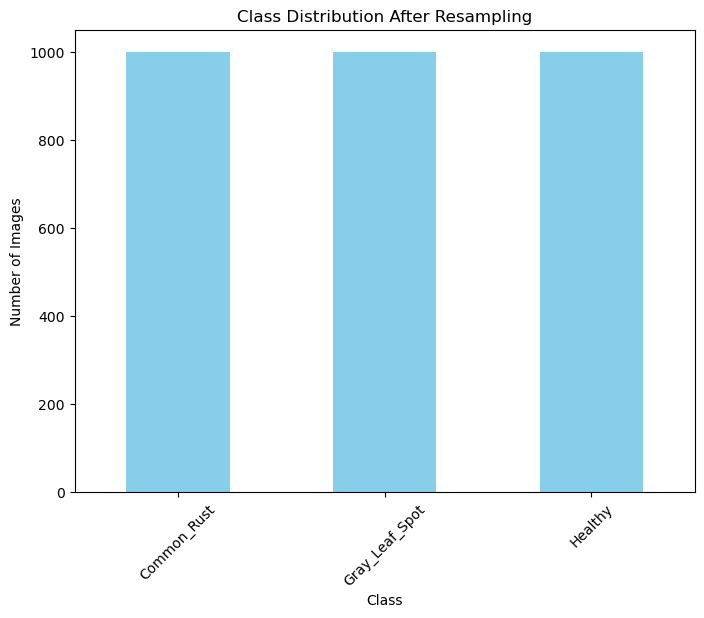

In [20]:
# Optionally, plot the class distribution again after resampling
plt.figure(figsize=(8, 6))
df_resampled['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution After Resampling')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [21]:
# Split the data into features (X) and labels (y)
X = df_resampled['image_path']  # Image file paths (features)
y = df_resampled['label']       # Labels (target)

In [22]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
# Create DataFrames for train and test sets
train_df = pd.DataFrame({'image_path': X_train, 'label': y_train})
test_df = pd.DataFrame({'image_path': X_test, 'label': y_test})

In [24]:
# Verify the distribution of classes in the train and test sets
print("\nClass Distribution in Train Set:")
print(train_df['label'].value_counts())

print("\nClass Distribution in Test Set:")
print(test_df['label'].value_counts())


Class Distribution in Train Set:
label
Healthy           800
Common_Rust       800
Gray_Leaf_Spot    800
Name: count, dtype: int64

Class Distribution in Test Set:
label
Healthy           200
Gray_Leaf_Spot    200
Common_Rust       200
Name: count, dtype: int64


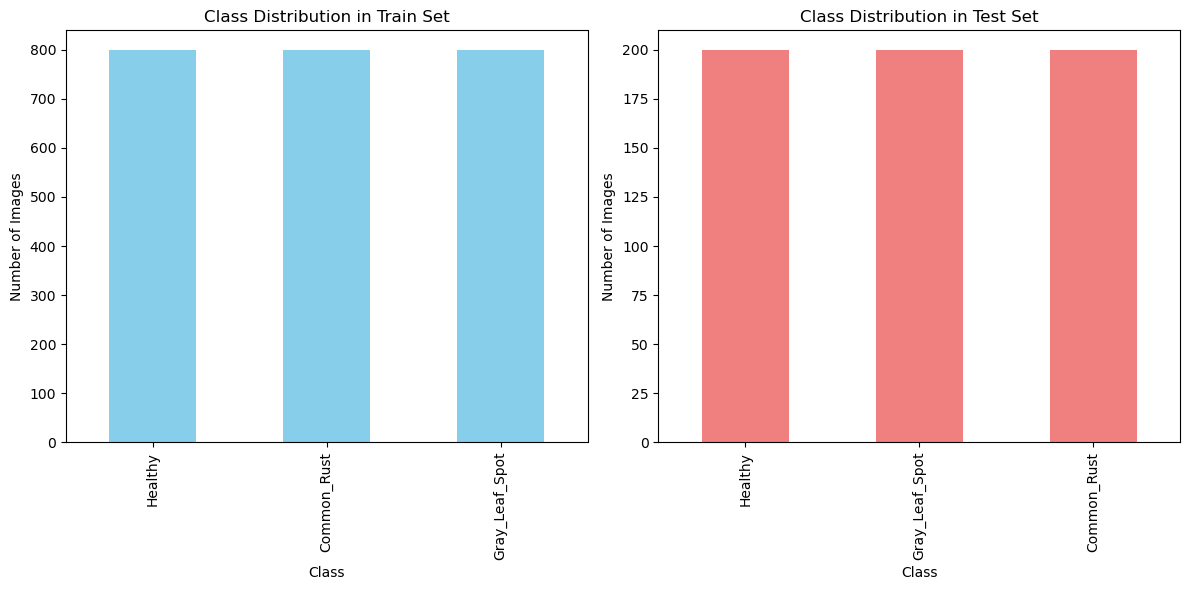

In [25]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
train_df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution in Train Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')

plt.subplot(1, 2, 2)
test_df['label'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Class Distribution in Test Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

In [26]:
# Set image size and batch size
image_size = (224, 224)  # Updated image size
batch_size = 32

In [27]:
# Create ImageDataGenerators for data augmentation and scaling
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values to [0, 1]
    rotation_range=20,            # Random rotations
    width_shift_range=0.2,        # Horizontal shift
    height_shift_range=0.2,       # Vertical shift
    shear_range=0.2,              # Shear transformation
    zoom_range=0.2,               # Zoom in/out
    horizontal_flip=True,         # Random horizontal flip
    fill_mode='nearest'           # Fill mode for missing pixels
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for test data

In [28]:
# Flow from dataframe to load images for training
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',            # Column with image paths
    y_col='label',                 # Column with labels
    target_size=image_size,        # Resize images to 224x224
    batch_size=batch_size,
    class_mode='sparse',           # Integer labels
    shuffle=True,
    seed=42
)

# Flow from dataframe to load images for testing
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',            # Column with image paths
    y_col='label',                 # Column with labels
    target_size=image_size,        # Resize images to 224x224
    batch_size=batch_size,
    class_mode='sparse',           # Integer labels
    shuffle=False,                 # No shuffling for evaluation
    seed=42
)

Found 2400 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.


In [29]:
# Build the CNN model
model = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the output
    layers.Flatten(),

    # Fully Connected (Dense) Layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    layers.Dense(3, activation='softmax')  # 3 output classes: EarlyBlight, LateBlight, Healthy
])

C:\Users\Win\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Sparse labels (integer-based loss)
              metrics=['accuracy'])

In [31]:
# Model summary to check architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Set up callbacks for Early Stopping and Learning Rate Scheduler
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5,  # Stop if no improvement in validation loss for 5 epochs
                               restore_best_weights=True,
                               verbose=1)

# Learning Rate Scheduler (Reduce learning rate when validation loss plateaus)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.5,  # Reduce LR by 50%
                                  patience=3,  # If no improvement for 3 epochs
                                  min_lr=1e-6, # Minimum learning rate
                                  verbose=1)

In [33]:
# Train the model
history = model.fit(
    train_generator,
    epochs=50,  # You can adjust the number of epochs
    validation_data=test_generator,
    callbacks=[early_stopping, lr_scheduler]  # Include the callbacks
)

Epoch 1/50


C:\Users\Win\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 810ms/step - accuracy: 0.6848 - loss: 0.8039 - val_accuracy: 0.9017 - val_loss: 0.4065 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 58s 740ms/step - accuracy: 0.9257 - loss: 0.2424 - val_accuracy: 0.9517 - val_loss: 0.1713 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 58s 741ms/step - accuracy: 0.9593 - loss: 0.1617 - val_accuracy: 0.9633 - val_loss: 0.1356 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 58s 734ms/step - accuracy: 0.9466 - loss: 0.1777 - val_accuracy: 0.9500 - val_loss: 0.1846 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 58s 736ms/step - accuracy: 0.9491 - loss: 0.1578 - val_accuracy: 0.9550 - val_loss: 0.1365 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9685 - loss: 0.1333
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
75/75 ━━━━━━━━━━━━━━━━━━━━ 58s 738ms/step - accuracy: 0.9684 - loss: 0.1332 - val_ac

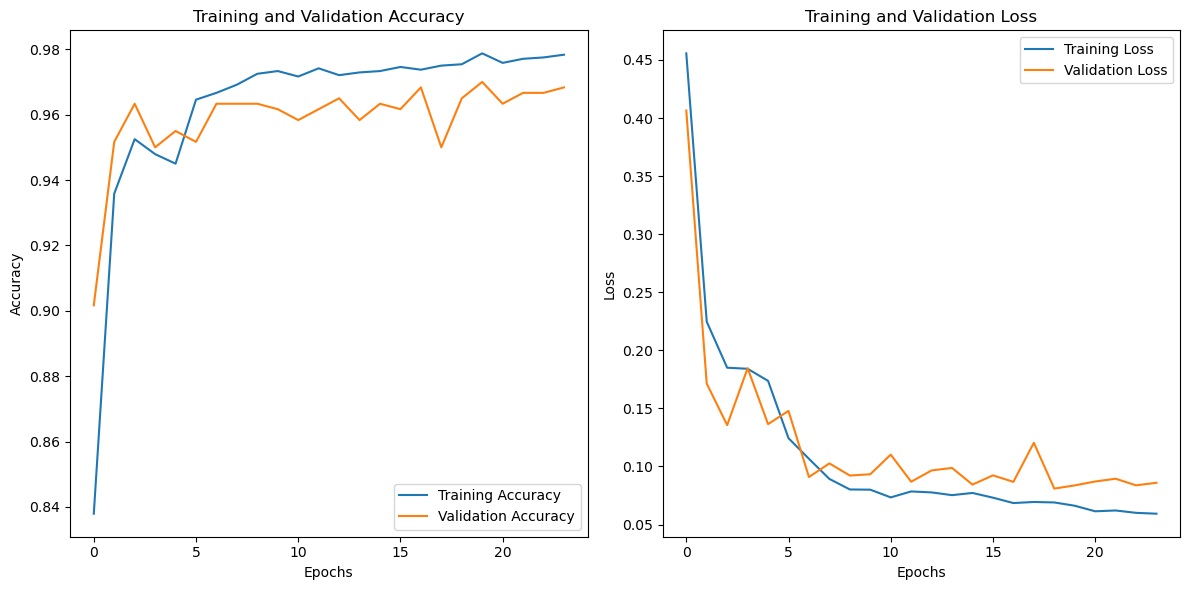

In [34]:
# Plot accuracy and loss graphs
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
y_true = test_generator.labels  # True labels from the test set
y_pred_prob = model.predict(test_generator, verbose=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step


In [36]:
# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)  # Get the index of the highest probability

In [37]:
# Generate the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

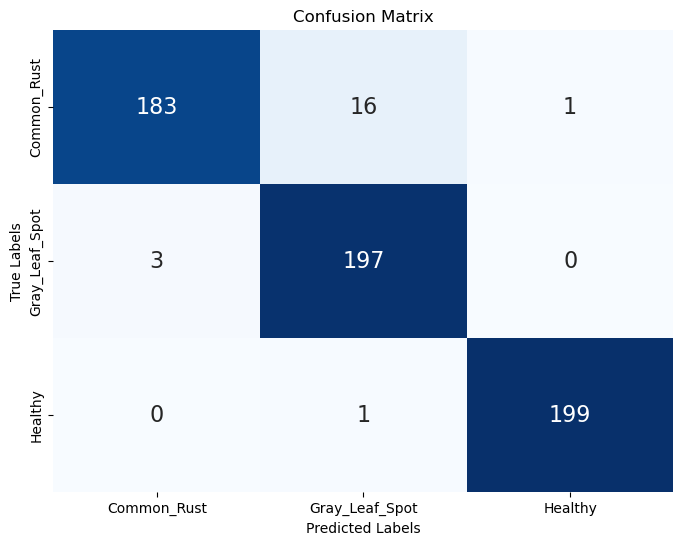

In [38]:
# Plot the Confusion Matrix using Seaborn Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys(), cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [39]:
# Generate the Classification Report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)

                precision    recall  f1-score   support

   Common_Rust       0.98      0.92      0.95       200
Gray_Leaf_Spot       0.92      0.98      0.95       200
       Healthy       0.99      0.99      0.99       200

      accuracy                           0.96       600
     macro avg       0.97      0.96      0.96       600
  weighted avg       0.97      0.96      0.96       600



In [40]:
model.save('corn_CNN_model.keras')

In [58]:
# Load VGG16 pre-trained model with weights from ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the VGG model
base_model.trainable = False

# Add custom layers on top of the VGG base model
model_vgg = models.Sequential([
    base_model,  # Add VGG16 base model
    layers.GlobalAveragePooling2D(),  # Global average pooling layer to reduce dimensionality
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    layers.Dense(3, activation='softmax')  # Output layer for 3 classes (EarlyBlight, LateBlight, Healthy)
])

In [59]:
model_vgg.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Sparse labels (integer-based loss)
              metrics=['accuracy'])

# Model summary to check architecture
model_vgg.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [62]:
# Train the model with the callbacks
history = model_vgg.fit(
    train_generator,
    epochs=5,  # You can increase the number of epochs
    validation_data=test_generator,
    callbacks=[lr_scheduler]  # Include the callbacks
)

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 324s 4s/step - accuracy: 0.5922 - loss: 0.8785 - val_accuracy: 0.9317 - val_loss: 0.3029 - learning_rate: 0.0010
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 302s 4s/step - accuracy: 0.8937 - loss: 0.3613 - val_accuracy: 0.9300 - val_loss: 0.2321 - learning_rate: 0.0010
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 325s 4s/step - accuracy: 0.9144 - loss: 0.2729 - val_accuracy: 0.9483 - val_loss: 0.1773 - learning_rate: 0.0010
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 315s 4s/step - accuracy: 0.9131 - loss: 0.2762 - val_accuracy: 0.9517 - val_loss: 0.1637 - learning_rate: 0.0010
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 313s 4s/step - accuracy: 0.9300 - loss: 0.2028 - val_accuracy: 0.9400 - val_loss: 0.1786 - learning_rate: 0.0010


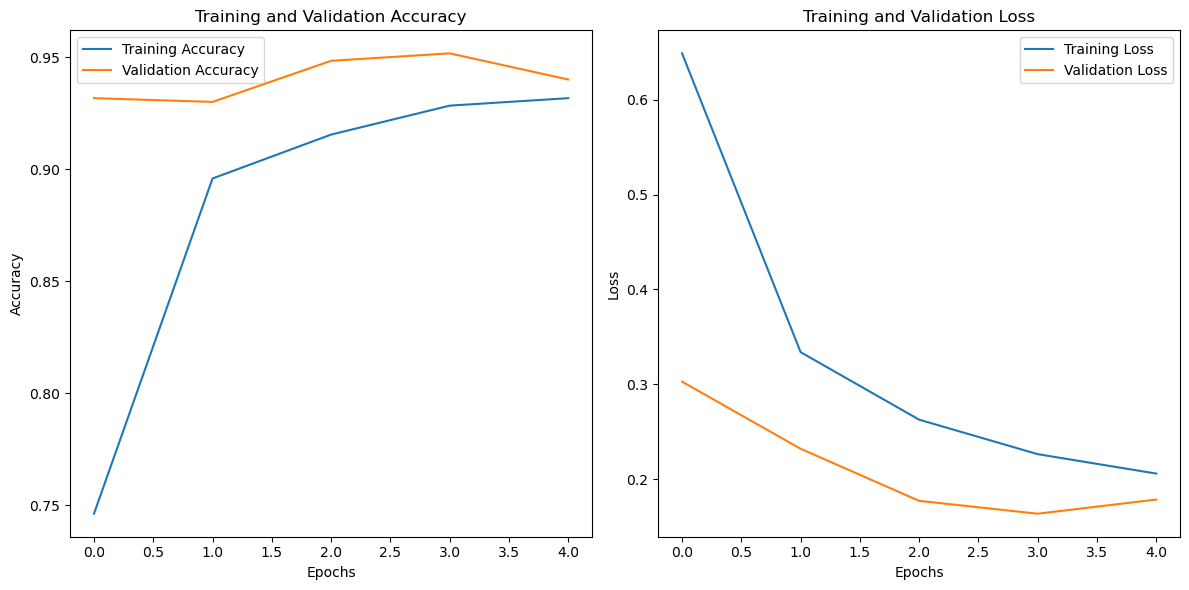

In [63]:
# Plot accuracy and loss graphs
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step


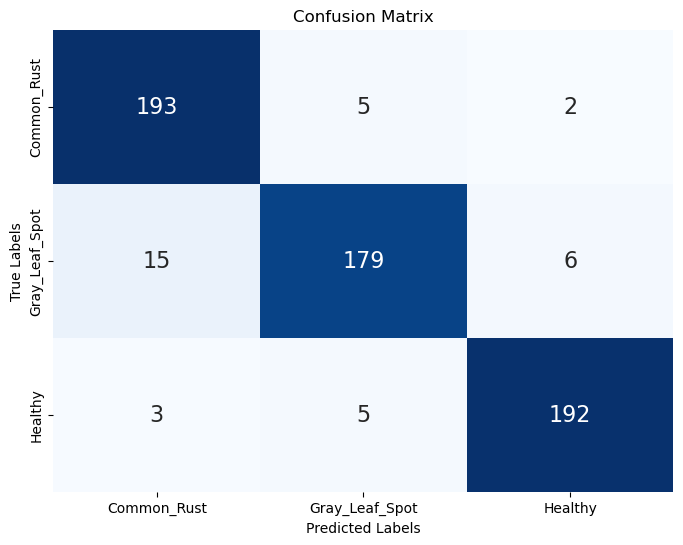

In [64]:
# Generate Predictions on Test Data
y_true = test_generator.labels  # True labels from the test set
y_pred_prob = model_vgg.predict(test_generator, verbose=1)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)  # Get the index of the highest probability

# Generate the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the Confusion Matrix using Seaborn Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys(), cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [65]:
# Generate the Classification Report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)

                precision    recall  f1-score   support

   Common_Rust       0.91      0.96      0.94       200
Gray_Leaf_Spot       0.95      0.90      0.92       200
       Healthy       0.96      0.96      0.96       200

      accuracy                           0.94       600
     macro avg       0.94      0.94      0.94       600
  weighted avg       0.94      0.94      0.94       600



In [66]:
model_vgg.save('corn_VGG_model.keras')